In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
gulerosman_hg14_handgesture14_dataset_path = kagglehub.dataset_download('gulerosman/hg14-handgesture14-dataset')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hg14-handgesture14-dataset/HG14/Read.docx
/kaggle/input/hg14-handgesture14-dataset/HG14/HG14-Hand Gesture/Gesture_11/11925.jpg
/kaggle/input/hg14-handgesture14-dataset/HG14/HG14-Hand Gesture/Gesture_11/11378.jpg
/kaggle/input/hg14-handgesture14-dataset/HG14/HG14-Hand Gesture/Gesture_11/11138.jpg
/kaggle/input/hg14-handgesture14-dataset/HG14/HG14-Hand Gesture/Gesture_11/11868.jpg
/kaggle/input/hg14-handgesture14-dataset/HG14/HG14-Hand Gesture/Gesture_11/11034.jpg
/kaggle/input/hg14-handgesture14-dataset/HG14/HG14-Hand Gesture/Gesture_11/11251.jpg
/kaggle/input/hg14-handgesture14-dataset/HG14/HG14-Hand Gesture/Gesture_11/11617.jpg
/kaggle/input/hg14-handgesture14-dataset/HG14/HG14-Hand Gesture/Gesture_11/11921.jpg
/kaggle/input/hg14-handgesture14-dataset/HG14/HG14-Hand Gesture/Gesture_11/11236.jpg
/kaggle/input/hg14-handgesture14-dataset/HG14/HG14-Hand Gesture/Gesture_11/11522.jpg
/kaggle/input/hg14-handgesture14-dataset/HG14/HG14-Hand Gesture/Gesture_11/11529.jpg
/kaggle/i

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import os
import time
import copy

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # Focus on hand regions
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.3, 0.3, 0.3),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))  # Paper's augmentation
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Load dataset
data_dir = '/kaggle/input/hg14-handgesture14-dataset/HG14/HG14-Hand Gesture'  # Path to HG14 dataset
num_classes = 14
batch_size = 32  # Reduced from paper's 20 for better GPU utilization

full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])

# Split dataset (70% train, 15% val, 15% test)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Initialize MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# Modify classifier head with dropout (as in paper)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Paper's dropout rate
    nn.Linear(model.last_channel, num_classes)
)
model = model.to(device)

# Loss function with label smoothing (reduces overfitting)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Mixed precision training
scaler = torch.cuda.amp.GradScaler(enabled=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 154MB/s]
/tmp/ipykernel_35/1876732582.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = to

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            # Mixed precision forward
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_dataset)
        val_acc = val_corrects.double() / len(val_dataset)
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Update best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Train the model
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)


Epoch 1/10
----------


/tmp/ipykernel_35/1907092780.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 1.2694 Acc: 0.7157
Val Loss: 1.1221 Acc: 0.7700
Epoch 2/10
----------
Train Loss: 0.9165 Acc: 0.8723
Val Loss: 0.8233 Acc: 0.9129
Epoch 3/10
----------
Train Loss: 0.8243 Acc: 0.9117
Val Loss: 0.8057 Acc: 0.9157
Epoch 4/10
----------
Train Loss: 0.7641 Acc: 0.9331
Val Loss: 0.7522 Acc: 0.9310
Epoch 5/10
----------
Train Loss: 0.7297 Acc: 0.9453
Val Loss: 0.6988 Acc: 0.9529
Epoch 6/10
----------
Train Loss: 0.6964 Acc: 0.9557
Val Loss: 0.6689 Acc: 0.9633
Epoch 7/10
----------
Train Loss: 0.6718 Acc: 0.9626
Val Loss: 0.6392 Acc: 0.9714
Epoch 8/10
----------
Train Loss: 0.6448 Acc: 0.9733
Val Loss: 0.6159 Acc: 0.9795
Epoch 9/10
----------
Train Loss: 0.6344 Acc: 0.9750
Val Loss: 0.6042 Acc: 0.9810
Epoch 10/10
----------
Train Loss: 0.6225 Acc: 0.9796
Val Loss: 0.6078 Acc: 0.9805


In [ ]:
# Save the model
torch.save(model.state_dict(), 'mobilenetv2_hg14.pth')

In [ ]:
# Test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

test_model(model, test_loader)

Test Accuracy: 98.48%


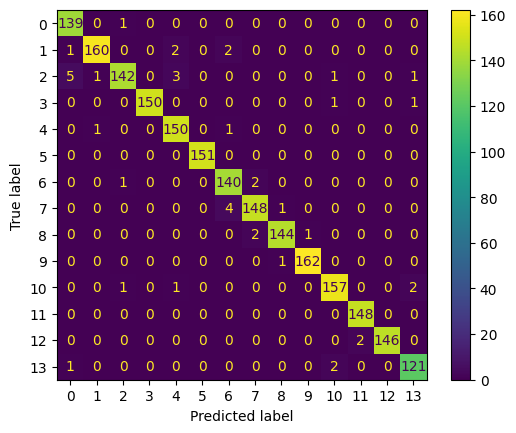

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()


_______________________________________________________________________________________________

-----------------------------------------------------------------------------------------------------